<a href="https://colab.research.google.com/github/SRK93/CatsVsDogs/blob/main/CatVsDog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [ ]:
alldata, ds_info = tfds.load('cats_vs_dogs', split=['train'],
                           shuffle_files=True, as_supervised=True,
                           with_info=True)

In [ ]:
print(ds_info)

tfds.core.DatasetInfo(
    name='cats_vs_dogs',
    version=4.0.0,
    description='A large set of images of cats and dogs.There are 1738 corrupted images that are dropped.',
    homepage='https://www.microsoft.com/en-us/download/details.aspx?id=54765',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=23262,
    splits={
        'train': 23262,
    },
    supervised_keys=('image', 'label'),
    citation="""@Inproceedings (Conference){asirra-a-captcha-that-exploits-interest-aligned-manual-image-categorization,
    author = {Elson, Jeremy and Douceur, John (JD) and Howell, Jon and Saul, Jared},
    title = {Asirra: A CAPTCHA that Exploits Interest-Aligned Manual Image Categorization},
    booktitle = {Proceedings of 14th ACM Conference on Computer and Communications Security (CCS)},
    ye

In [ ]:
test_data = alldata[0].take(3000)
train_data = alldata[0].skip(3000)

In [ ]:
labels = ds_info.features['label'].names

(246, 232, 3)


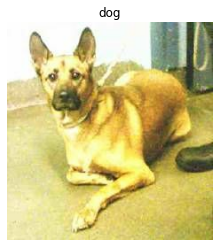

In [ ]:
for image, label in test_data.take(1):
  plt.imshow(image)
  plt.title(labels[label.numpy()])
  plt.axis(False)
  print(image.shape)

In [ ]:
def process_image(image, label):
  img = tf.image.resize(image, [224,224])
  return tf.cast(img, dtype=tf.float32), label

In [ ]:
# Map preprocessing function to training data (and paralellize)
train_data = train_data.map(map_func=process_image, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map prepreprocessing function to test data
test_data = test_data.map(process_image, num_parallel_calls=tf.data.AUTOTUNE)
# Turn test data into batches (don't need to shuffle)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy="float32") # set global policy to mixed precision 

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False # freeze base model layers

# Create Functional model 
inputs = layers.Input(shape=input_shape, name="input_layer")
# Note: EfficientNetBX models have rescaling built-in but if your model didn't you could have a layer like below
# x = preprocessing.Rescaling(1./255)(x)
x = base_model(inputs, training=False) # set base_model to inference mode only
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dense(len(labels))(x) # want one output neuron per class 
# Separate activation of output layer so we can output float32 activations
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x) 
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss="sparse_categorical_crossentropy", # Use sparse_categorical_crossentropy when labels are *not* one-hot
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [ ]:
history_1_feature_extraction = model.fit(train_data, epochs=5,
                                         steps_per_epoch=len(train_data),
                                         validation_data=test_data,
                                         validation_steps=len(test_data))

Epoch 1/5
634/634 [==============================] - 76s 108ms/step - loss: 0.0500 - accuracy: 0.9853 - val_loss: 0.0317 - val_accuracy: 0.9887
Epoch 2/5
634/634 [==============================] - 70s 106ms/step - loss: 0.0242 - accuracy: 0.9924 - val_loss: 0.0284 - val_accuracy: 0.9893
Epoch 3/5
634/634 [==============================] - 71s 107ms/step - loss: 0.0201 - accuracy: 0.9935 - val_loss: 0.0288 - val_accuracy: 0.9903
Epoch 4/5
634/634 [==============================] - 71s 106ms/step - loss: 0.0175 - accuracy: 0.9945 - val_loss: 0.0300 - val_accuracy: 0.9897
Epoch 5/5
634/634 [==============================] - 71s 106ms/step - loss: 0.0155 - accuracy: 0.9958 - val_loss: 0.0323 - val_accuracy: 0.9893


In [ ]:
results_feature_extraction = model.evaluate(test_data)
results_feature_extraction

94/94 [==============================] - 9s 89ms/step - loss: 0.0317 - accuracy: 0.9900


[0.03169040009379387, 0.9900000095367432]

In [ ]:
test_image = plt.imread("/content/photo6275795188190391416.jpg")

In [ ]:
test_image_processed, _ = process_image(test_image,0)

In [ ]:
prediction = model.predict(tf.expand_dims(test_image_processed,axis=0))

In [ ]:
predicted_class = labels[tf.argmax(prediction, axis=1).numpy()[0]]
pred_prob = tf.reduce_max(prediction)

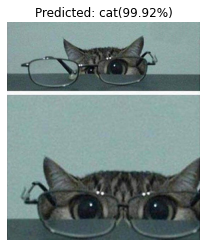

In [ ]:
plt.imshow(test_image)
plt.title('Predicted: '+predicted_class+f'({pred_prob*100:.2f}%)')
plt.axis(False);

In [ ]:
model.save('CatsVsDogs/')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: CatsVsDogs/assets


INFO:tensorflow:Assets written to: CatsVsDogs/assets


In [ ]:
!zip -r /content/CatsVsDogs_model.zip /content/CatsVsDogs
from google.colab import files
files.download("/content/CatsVsDogs_model.zip")

  adding: content/CatsVsDogs/ (stored 0%)
  adding: content/CatsVsDogs/keras_metadata.pb (deflated 96%)
  adding: content/CatsVsDogs/variables/ (stored 0%)
  adding: content/CatsVsDogs/variables/variables.index (deflated 73%)
  adding: content/CatsVsDogs/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: content/CatsVsDogs/saved_model.pb (deflated 92%)
  adding: content/CatsVsDogs/assets/ (stored 0%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>